In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from statistics import NormalDist
import glob
from collections import defaultdict

from scipy.stats import ttest_ind

In [3]:

label_f = '~/Ephys/Data/all_pats_bipole_soz_labels.csv'
label_df = pd.read_csv(label_f, header=None)
label_df.columns = ['subj','bipole','label']
label_df.head(4)


,subj,bipole,label
0,Epat31,AH3-AH4,1
1,Epat31,AH4-AH5,1
2,Epat31,AH5-AH6,1
3,Epat31,PH1-PH2,1


In [4]:
def split_bipole(bip_df: pd.DataFrame):
    """splits the bipole column of a bipole df
    duplicates rows

    """
    assert 'bipole' in bip_df.columns, "Need bipole column!"

    contact1 = bip_df.bipole.apply(lambda x: x.split("-")[0].strip(" "))
    contact2 = bip_df.bipole.apply(lambda x: x.split("-")[1].strip(" "))
# python resultAggregator.py -s 'Epat38' -p '/mnt/ernie_main/Ghassan/ephys/data/Epat38'
    df2 = bip_df.copy(deep=True)

    bip_df['contact'] = contact1
    df2['contact'] = contact2


    return pd.concat([bip_df,df2])

def map_label(label):
    label = int(label)
    match label:
        case 0:
            return "NIZ"
        case 1:
            return 'SOZ'
        case 2:
            return 'PZ'
        case 3:
            return 'IZ'
        
def merge_label(subj_df: pd.DataFrame, label_df: pd.DataFrame, leftcol: str, rightcol: str ) -> pd.DataFrame:
    """Merges contact label into the subj_df for both stim and response regions

    Args:
        subj_df (pd.DataFrame): dataframe with SPES data, could be CRP, raw SPES, etc
        as long as each row has an entry for a bipole (or monopolar) contact to merge on. 
        ASSUMES 'subj' is a column for sanity checks.
       
        label_df (pd.DataFrame): labels designating 'SOZ', 'NIZ', 'PZ', should be originating 
        from the 'all_pats_bipole.csv', may contain more than one subject, but ASSUMES 'subj' is a column.

        leftcol (str): column of subject bipoles, could be stim, or resp, will be renamed
        'leftcol_label'

       merge_labeleturns:
        pd.DataFrame: subj df with columns for labels
    """
    assert 'subj' in subj_df.columns, "Need a 'subj' column! in subj_df"
    assert 'subj' in label_df.columns, "Needa 'subj' column in label_df"
    assert 'label' in label_df.columns, "Need a label to merge into subj_df, check label_df!"
    assert subj_df.subj.values[0] in set(label_df.subj.values) ,"Subject missing from label df!"
    assert len(set(subj_df.subj)) == 1, 'Can only merge one subject at a time!'
    og_rows = subj_df.shape[0]
    subj = subj_df.subj.values[0]
    label_df = label_df[label_df.subj == subj]
    reg_map = defaultdict(lambda: "UNLABELED")
    reg_map.update({reg:label for reg,label in label_df[[rightcol,'label']].values})
    subj_df[ f'{leftcol}_label'] = subj_df[leftcol].apply(lambda x: reg_map[x])  # subj_df = subj_df.merge(label_df[[rightcol, 'label']], left_on=leftcol, right_on=rightcol)
    assert og_rows >= subj_df.shape[0], f"For {subj}\n\t\texpected at most {og_rows}, after merge: {subj_df.shape[0]} rows detected"
    return subj_df



label_f = '~/Ephys/Data/all_pats_bipole_soz_labels.csv'
label_df = pd.read_csv(label_f, header=None)
label_df.columns = ['subj','bipole','label']



label_df = split_bipole(label_df)

label_df.label = label_df.label.apply(map_label)
label_df['bipole'] = label_df.bipole.apply(lambda x: x.replace(" ", ""))

relabel = defaultdict(lambda:"NIZ")
relabel['SOZ'] = 'SOZ' 
label_df['label'] = [relabel[x] for x in label_df.label.values]



In [6]:
label_df

,subj,bipole,label,contact
0,Epat31,AH3-AH4,SOZ,AH3
1,Epat31,AH4-AH5,SOZ,AH4
2,Epat31,AH5-AH6,SOZ,AH5
3,Epat31,PH1-PH2,SOZ,PH1
4,Epat31,PH2-PH3,SOZ,PH2
...,...,...,...,...
7048,Spat55,LCM6-LCM7,NIZ,LCM7
7049,Spat55,LCM8-LCM9,NIZ,LCM9
7050,Spat55,LCM9-LCM10,NIZ,LCM10
7051,Spat55,LCM10-LCM11,NIZ,LCM11


In [11]:
tst = '/mnt/ernie_main/Ghassan/ephys/data/Epat26/Epat26_stim.csv'
tst_df = pd.read_csv(tst)
tmp = merge_label(tst_df,label_df, 'resp_reg', 'bipole')


,Unnamed: 0,alphas,TR,resp_reg,alpha_prime,explained_variance,stim_reg,ma,subj,resp_reg_label
140,0,-480.059892,0.250000,LAH1-LAH2,-3.750468,0.528119,LAC3-LAC4,5mA,Epat26,SOZ
141,1,-291.565601,0.250000,LAH1-LAH2,-2.277856,0.575238,LAC3-LAC4,5mA,Epat26,SOZ
142,2,-510.000714,0.250000,LAH1-LAH2,-3.984381,0.525714,LAC3-LAC4,5mA,Epat26,SOZ
143,3,75.719654,0.250000,LAH1-LAH2,0.591560,0.034803,LAC3-LAC4,5mA,Epat26,SOZ
144,4,-80.730931,0.250000,LAH1-LAH2,-0.630710,0.045337,LAC3-LAC4,5mA,Epat26,SOZ
...,...,...,...,...,...,...,...,...,...,...
250059,5,253.077086,0.546875,RH4-RH5,0.903847,0.040992,LAM13-LAM14,4mA,Epat26,SOZ
250060,6,-654.144550,0.546875,RH4-RH5,-2.336231,0.328640,LAM13-LAM14,4mA,Epat26,SOZ
250061,7,307.629711,0.546875,RH4-RH5,1.098678,0.174066,LAM13-LAM14,4mA,Epat26,SOZ
250062,8,-227.434452,0.546875,RH4-RH5,-0.812266,0.058432,LAM13-LAM14,4mA,Epat26,SOZ


In [12]:
RES_FILES = glob.glob('/mnt/ernie_main/Ghassan/ephys/data/*pat*/*pat*_stim.csv')
print(RES_FILES)
import pdb
def agg_subject_results(result_files: list[str], label_df: pd.DataFrame) -> pd.DataFrame:
    dfs = []
    expected_rows = 0
    for f in result_files:
        res_df = pd.read_csv(f)
        subj = res_df.subj.values[0]
        res_df.resp_reg = res_df.resp_reg.apply(lambda x: x.replace(" ", ""))
        expected_rows += res_df.shape[0]
        tmp = merge_label(res_df,label_df, 'resp_reg', 'bipole')
        merge_df = merge_label(tmp, label_df, 'stim_reg', 'bipole')        
        dfs.append(merge_df)
    dfs = pd.concat(dfs)
    dfs = dfs[dfs.stim_reg_label != "UNLABELED"]
    dfs = dfs[dfs.resp_reg_label != "UNLABELED"]
    assert expected_rows >= dfs.shape[0], f"Expected at most {expected_rows}, got {dfs.shape[0]}\n\t\t diff: {expected_rows - dfs.shape[0]}"
    print(f"{len(set(dfs.subj))} subjects, total of {dfs.shape[0]} trials, dropped: {expected_rows - dfs.shape[0]}")
    return dfs

res_df = agg_subject_results(RES_FILES, label_df.drop_duplicates())


['/mnt/ernie_main/Ghassan/ephys/data/Epat26/Epat26_stim.csv', '/mnt/ernie_main/Ghassan/ephys/data/Spat30/Spat30_stim.csv', '/mnt/ernie_main/Ghassan/ephys/data/Epat27/Epat27_stim.csv', '/mnt/ernie_main/Ghassan/ephys/data/Epat30/Epat30_stim.csv', '/mnt/ernie_main/Ghassan/ephys/data/Epat31/Epat31_stim.csv', '/mnt/ernie_main/Ghassan/ephys/data/Epat31/Spat31_stim.csv', '/mnt/ernie_main/Ghassan/ephys/data/Spat52/Spat52_stim.csv', '/mnt/ernie_main/Ghassan/ephys/data/Spat34/Spat34_stim.csv', '/mnt/ernie_main/Ghassan/ephys/data/Epat35/Epat35_stim.csv', '/mnt/ernie_main/Ghassan/ephys/data/Epat37/Epat37_stim.csv', '/mnt/ernie_main/Ghassan/ephys/data/Epat37/Spat37_stim.csv', '/mnt/ernie_main/Ghassan/ephys/data/Epat38/Epat38_stim.csv', '/mnt/ernie_main/Ghassan/ephys/data/Epat39/Epat39_stim.csv', '/mnt/ernie_main/Ghassan/ephys/data/Epat43/Epat43_stim.csv', '/mnt/ernie_main/Ghassan/ephys/data/Spat36/Spat36_stim.csv', '/mnt/ernie_main/Ghassan/ephys/data/Spat37/Spat37_stim.csv']
15 subjects, total of 2

In [14]:
dist_df = pd.read_csv('/mnt/ernie_main/000_Data/SEEG/SEEG_EyesClosed_RestingState/labels/all_pats_euc_dist_list.csv',header=None)
dist_df.columns = ['subj', 'bipole1', 'bipole2','dist']
subj_set = set(res_df.subj)
dist_df = dist_df[dist_df.subj.isin(subj_set)]

In [11]:
dist_df['monopole1'] = dist_df.bipole2.apply(lambda x : x.split("-")[0])
dist_df['monopole2'] = dist_df.bipole2.apply(lambda x : x.split("-")[1])


In [15]:
dist_df

,subj,bipole1,bipole2,dist
220081,Epat26,LAC1-LAC2,LAC1-LAC2,0.0000
220082,Epat26,LAC1-LAC2,LP1-LP2,65.8629
220083,Epat26,LAC1-LAC2,LP2-LP3,65.3933
220084,Epat26,LAC1-LAC2,LTP1-LTP2,66.3953
220085,Epat26,LAC1-LAC2,LTP2-LTP3,66.1579
...,...,...,...,...
641337,Spat52,RA13-RA14,RA9-RA10,14.0442
641338,Spat52,RA13-RA14,RA10-RA11,10.5984
641339,Spat52,RA13-RA14,RA11-RA12,7.1626
641340,Spat52,RA13-RA14,RA12-RA13,3.5963


In [17]:
dist_map = defaultdict(lambda: -1)
dist_map.update({f'{subj}-{bip1}-{bip2}':d for subj,bip1,bip2,d in dist_df[['subj','bipole1','bipole2','dist']].values})
dist_map.update({f'{subj}-{bip2}-{bip1}':d for subj,bip1,bip2,d in dist_df[['subj','bipole1','bipole2','dist']].values})

tst_df = res_df.copy(deep=True)
tst_df['dist'] = [dist_map[f"{subj}-{stim_reg}-{resp_reg}"] for subj,stim_reg,resp_reg in tst_df[['subj','stim_reg','resp_reg']].values]

In [18]:
resdist_df = tst_df

In [19]:
resdist_df

,Unnamed: 0,alphas,TR,resp_reg,alpha_prime,explained_variance,stim_reg,ma,subj,resp_reg_label,stim_reg_label,dist
0,0,-529.205631,0.648438,LA1-LA2,-1.593993,0.874194,LAC3-LAC4,5mA,Epat26,NIZ,NIZ,70.6798
1,1,-62.771258,0.648438,LA1-LA2,-0.189070,0.043839,LAC3-LAC4,5mA,Epat26,NIZ,NIZ,70.6798
2,2,-19.609674,0.648438,LA1-LA2,-0.059065,0.002973,LAC3-LAC4,5mA,Epat26,NIZ,NIZ,70.6798
3,3,37.714351,0.648438,LA1-LA2,0.113597,0.020404,LAC3-LAC4,5mA,Epat26,NIZ,NIZ,70.6798
4,4,-18.288830,0.648438,LA1-LA2,-0.055087,0.003170,LAC3-LAC4,5mA,Epat26,NIZ,NIZ,70.6798
...,...,...,...,...,...,...,...,...,...,...,...,...
176374,5,12.702502,0.843750,RTT8-RTT9,0.029404,0.001591,ROF13-ROF14,1mA,Spat37,NIZ,NIZ,36.1295
176375,6,154.109342,0.843750,RTT8-RTT9,0.356735,0.202968,ROF13-ROF14,1mA,Spat37,NIZ,NIZ,36.1295
176376,7,360.964959,0.843750,RTT8-RTT9,0.835567,0.390444,ROF13-ROF14,1mA,Spat37,NIZ,NIZ,36.1295
176377,8,129.037641,0.843750,RTT8-RTT9,0.298698,0.131201,ROF13-ROF14,1mA,Spat37,NIZ,NIZ,36.1295


In [50]:
#Filtera conditions
resdist_df = resdist_df[resdist_df.dist > 10]
resdist_df = resdist_df[resdist_df.ma == '3mA']
#resdist_df = resdist_df[resdist_df.TR > 20]

In [51]:
cols = ['subj','stim_reg','resp_reg','alphas','alpha_prime','TR','dist', "resp_reg_label","stim_reg_label"]
group = resdist_df[cols].groupby(['subj','resp_reg', 'stim_reg',"resp_reg_label","stim_reg_label"])
group_df = group.mean()

In [52]:
# group_df


In [53]:
resdist_df['stim_rel'] = [f"{a}-{b}" for a,b in resdist_df[['resp_reg_label','stim_reg_label']].values]
resdist_df['stim_sesh'] = [f"{stim}-{resp}" for stim, resp in resdist_df[['stim_reg','resp_reg']].values ]
stim_rel_map = {f"{subj}-{stim_sesh}":stim_rel for subj,stim_sesh,stim_rel in resdist_df[['subj','stim_sesh','stim_rel']].values}

In [54]:

tmp =resdist_df[['subj','explained_variance', 'dist', 'stim_sesh']].groupby(["subj","stim_sesh"]).mean().reset_index()
tmp['stim_rel'] = [stim_rel_map[f'{subj}-{stim_sesh}'] for subj,stim_sesh in tmp[['subj', 'stim_sesh']].values]
ev_dist_df = tmp

In [55]:
ev_dist_df

,subj,stim_sesh,explained_variance,dist,stim_rel
0,Epat26,LA1-LA2-LA4-LA5,0.804629,10.3208,NIZ-NIZ
1,Epat26,LA1-LA2-LA5-LA6,0.884168,13.9337,NIZ-NIZ
2,Epat26,LA1-LA2-LA6-LA7,0.806821,17.5366,NIZ-NIZ
3,Epat26,LA1-LA2-LAC1-LAC2,0.491706,69.0552,NIZ-NIZ
4,Epat26,LA1-LA2-LAC3-LAC4,0.345968,70.6798,NIZ-NIZ
...,...,...,...,...,...
64087,Spat52,RTF6-RTF7-RH5-RH6,0.169286,28.7518,NIZ-NIZ
64088,Spat52,RTF6-RTF7-RH6-RH7,0.359609,28.6646,NIZ-NIZ
64089,Spat52,RTF6-RTF7-RTF1-RTF2,0.501431,17.4268,NIZ-NIZ
64090,Spat52,RTF6-RTF7-RTF2-RTF3,0.955672,14.1251,NIZ-NIZ


tmp.shape

In [56]:
# get NIZ stats
def get_NIZ_stats(df):
    return
sub_niz = dict()
sub_niz_tr = dict()
sub_niz_ev = dict()
for subj in set(resdist_df.subj):
    sub_df = resdist_df[resdist_df.subj==subj]
    niz_sub_df = sub_df[sub_df.stim_rel =="NIZ-NIZ"]
    mu = niz_sub_df.alpha_prime.mean()
    var = niz_sub_df.alpha_prime.std()
    sub_niz[subj] = (mu, var)

    
    mu = niz_sub_df.TR.mean()
    var = niz_sub_df.TR.std()
    sub_niz_tr[subj] = (mu, var)
    
    mu = niz_sub_df.explained_variance.mean()
    var = niz_sub_df.explained_variance.std()   
    sub_niz_ev[subj] = (mu, var)



print(f'TR stats:{  sub_niz_tr }')

print( f'alpha_prime stats: { sub_niz }' )



TR stats:{'Epat37': (0.3193218479480603, 0.29402752902892315), 'Epat26': (0.2709143666524581, 0.26074378349259913), 'Epat43': (0.34696492110148514, 0.27406463806096426), 'Spat34': (0.32203568827022894, 0.2850237760522419), 'Spat36': (0.3486418929628064, 0.28603936897789367), 'Spat30': (0.3146621107468977, 0.29005064680032316), 'Spat31': (0.2947706948788116, 0.3088411512116108), 'Epat30': (0.3237230963269454, 0.28234359229431427), 'Epat31': (0.38911247895622897, 0.27547711230568817), 'Epat38': (0.31734322039969215, 0.2868260632728187), 'Epat39': (0.3275531725285171, 0.29713746260053087), 'Spat52': (0.3719062868080094, 0.2978658115476736), 'Spat37': (0.34645408610498896, 0.28622624488354037), 'Epat27': (0.28749328305662614, 0.29174261398676177), 'Epat35': (0.3303298611111111, 0.2970803464518767)}
alpha_prime stats: {'Epat37': (-0.0915942645073544, 24.975460051638155), 'Epat26': (0.007152191038107604, 2.762136628474155), 'Epat43': (-0.135357956164359, 5.023046710566344), 'Spat34': (0.4799

In [58]:
# z score
experiment_df = resdist_df #[resdist_df.stim_rel.isin(['SOZ-SOZ','NIZ-SOZ','SOZ-NIZ'])]
dfs = []
for subj in set(experiment_df.subj):
    tmp = experiment_df[experiment_df.subj == subj]
    
    dist = NormalDist(*sub_niz[subj])
    tmp['alpha_z'] = tmp.alpha_prime.apply(dist.zscore)

    tr_dist = NormalDist(*sub_niz_tr[subj])
    tmp['TR_z'] = tmp.TR.apply(tr_dist.zscore)

    ev_dist = NormalDist(*sub_niz_ev[subj])
    tmp['ev_z'] = tmp.explained_variance.apply(ev_dist.zscore)
    dfs.append(tmp)

z_dfs = pd.concat(dfs)


    

/tmp/ipykernel_160893/853529833.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['alpha_z'] = tmp.alpha_prime.apply(dist.zscore)
/tmp/ipykernel_160893/853529833.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['TR_z'] = tmp.TR.apply(tr_dist.zscore)
/tmp/ipykernel_160893/853529833.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

In [ ]:
tmp = z_dfs[['subj','alpha_z','TR_z','explained_variance', 'stim_rel','dist']]
zgroup = tmp.groupby(['subj','stim_rel']).mean()
zgroup_df = zgroup.reset_index()
zgroup_df

/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

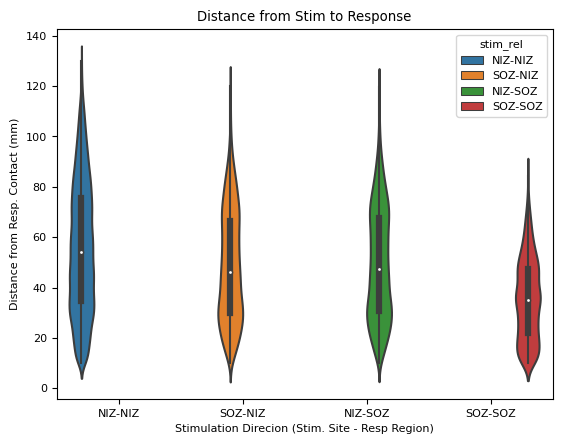

In [60]:
cols = ['NIZ-NIZ', 'SOZ-SOZ','SOZ-NIZ', 'NIZ-SOZ']

sns.violinplot(ev_dist_df[ev_dist_df.stim_rel.isin(cols)],y='dist', x='stim_rel',hue='stim_rel')
plt.ylabel("Distance from Resp. Contact (mm)")
plt.xlabel("Stimulation Direcion (Stim. Site - Resp Region)")
plt.title("Distance from Stim to Response")
plt.savefig("../viz/stim_dists.pdf", transparent=True)

In [73]:
def bin_distances(dist, binsize=2):
    return dist//binsize
ev_dist_df['dist_bin'] = ev_dist_df.dist.apply(bin_distances)


/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

<Axes: xlabel='dist_bin', ylabel='explained_variance'>

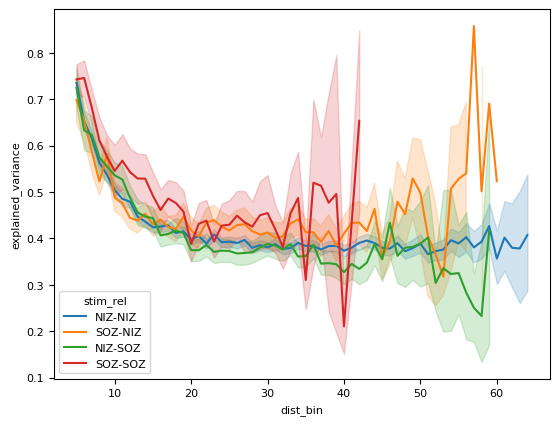

In [76]:
with sns.plotting_context("paper"):
    ax = sns.lineplot(ev_dist_df, x="dist_bin", y='explained_variance', hue='stim_rel')
    plt.label
    

/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

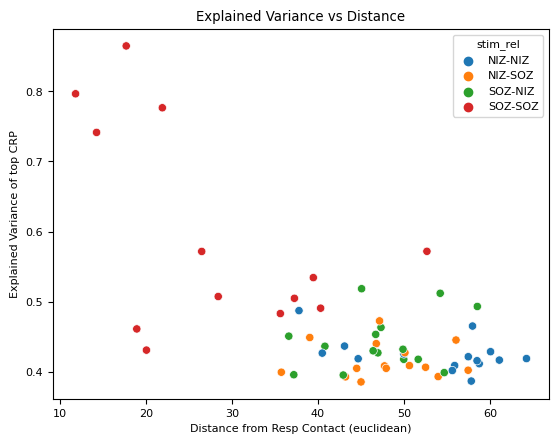

In [61]:
plot_df = ev_dist_df[['subj','stim_rel','dist','explained_variance']].groupby(['subj','stim_rel']).mean().reset_index()
# plot_df = ev_dist_df
cols = ['NIZ-NIZ', 'NIZ-SOZ', 'SOZ-SOZ', 'SOZ-NIZ']
sns.scatterplot(data=plot_df[plot_df.stim_rel.isin(cols)], x='dist', y='explained_variance', hue='stim_rel')
plt.title("Explained Variance vs Distance")
plt.xlabel("Distance from Resp Contact (euclidean)")
plt.ylabel("Explained Variance of top CRP")
plt.savefig(f"../viz/ev_by_stim_rel.pdf",transparent=True)

In [25]:
# sns.lineplot(data=zgroup_df, x='dist', y='explained_variance', hue='stim_rel')

/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

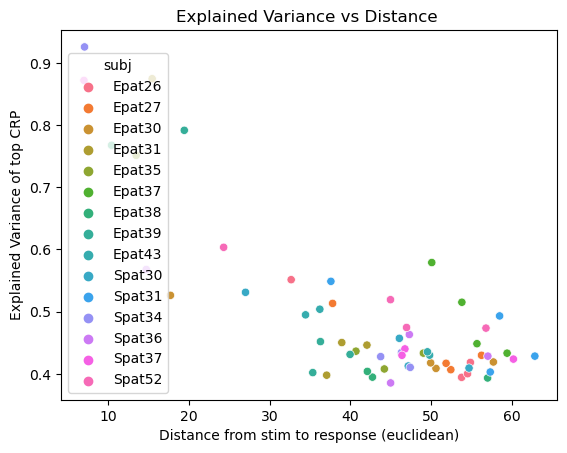

In [35]:

sns.scatterplot(data=zgroup_df, x='dist', y='explained_variance', hue='subj')
plt.title("Explained Variance vs Distance ")
plt.xlabel("Distance from stim to response (euclidean)")
plt.ylabel("Explained Variance of top CRP")
plt.savefig(f"../viz/ev_dist_from_soz.pdf",transparent=True)

In [42]:
tst_df = zgroup_df[zgroup_df.subj !='Spaaat34']
from scipy.stats import ttest_1samp

In [43]:
plt.rcParams.update({'font.size': 16})


/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

SOZ mean : -0.14590998376156486 vs NIZ->SOZ mean 0.006211054106708057
SOZ->NIZ: 0.0011455184185200954 vs NIZ->SOZ mean 0.006211054106708057
Comparing SOZ-SOZ to NIZ-SOZ: TtestResult(statistic=-1.0932483146533403, pvalue=0.2836015916074505, df=28.0)
Comparing SOZ-SOZ to NIZ-SOZ: TtestResult(statistic=-1.0577355081244986, pvalue=0.29921660221206703, df=28.0)


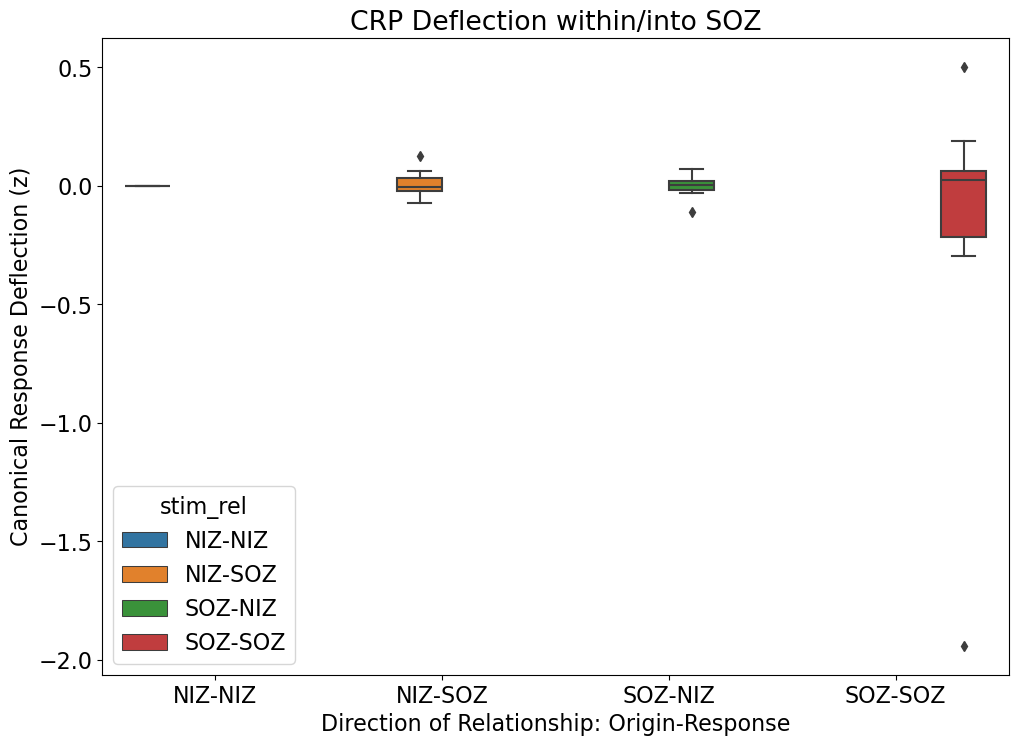

In [44]:
fig, ax = plt.subplots(figsize=[11.7,8.27])
cols = [ 'NIZ-NIZ', 'NIZ-SOZ', 'SOZ-SOZ', 'SOZ-NIZ']

ax = sns.boxplot(tst_df[tst_df.stim_rel.isin(cols)], x='stim_rel', y='alpha_z',hue='stim_rel',ax=ax)
a = tst_df[tst_df.stim_rel=='NIZ-SOZ'].alpha_z
b = tst_df[tst_df.stim_rel =='SOZ-SOZ'].alpha_z
c = tst_df[tst_df.stim_rel == 'SOZ-NIZ'].alpha_z
d =  tst_df[tst_df.stim_rel == 'NIZ-NIZ'].alpha_z

print(f"SOZ mean : {np.mean(b)} vs NIZ->SOZ mean {np.mean(a)}")

print(f"SOZ->NIZ: {np.mean(c)} vs NIZ->SOZ mean {np.mean(a)}")
print(f"Comparing SOZ-SOZ to NIZ-SOZ: {ttest_ind(b,a)}")
print(f"Comparing SOZ-SOZ to NIZ-SOZ: {ttest_ind(b,c)}")


plt.ylabel("Canonical Response Deflection (z)")
plt.xlabel("Direction of Relationship: Origin-Response")
plt.title("CRP Deflection within/into SOZ")
plt.savefig("../viz/relabel_boxplot_crp_alphaz_box.pdf", transparent=True)

In [ ]:
tst_df

/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

SOZ mean : -0.14590998376156486 vs NIZ->SOZ mean 0.006211054106708057
SOZ->NIZ: 0.0011455184185200954 vs NIZ->SOZ mean 0.006211054106708057
TtestResult(statistic=1.0932483146533403, pvalue=0.2836015916074505, df=28.0)


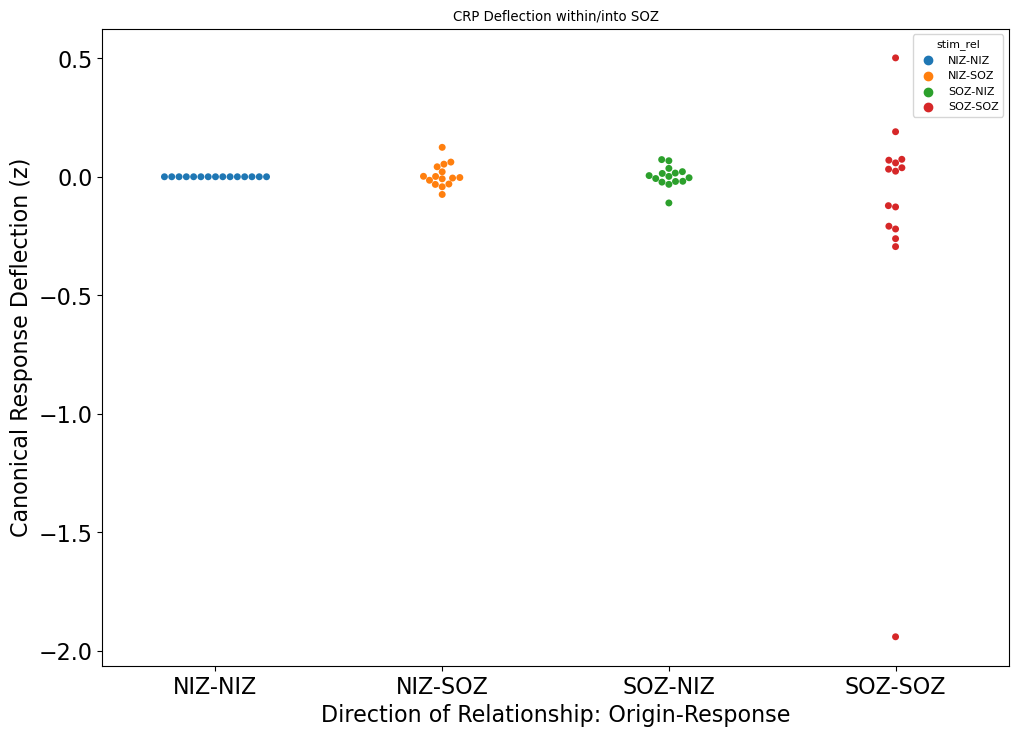

In [45]:
fig, ax = plt.subplots(figsize=[11.7,8.27])
plt.rcParams.update({'font.size': 8})
cols = [ 'NIZ-SOZ', 'SOZ-SOZ', 'SOZ-NIZ']


ax = sns.swarmplot(tst_df, x='stim_rel', y='alpha_z',hue='stim_rel',ax=ax)
a = tst_df[tst_df.stim_rel=='NIZ-SOZ'].alpha_z
b = tst_df[tst_df.stim_rel =='SOZ-SOZ'].alpha_z
c = tst_df[tst_df.stim_rel == 'SOZ-NIZ'].alpha_z
d =  tst_df[tst_df.stim_rel == 'PZ-PZ'].alpha_z

print(f"SOZ mean : {np.mean(b)} vs NIZ->SOZ mean {np.mean(a)}")

print(f"SOZ->NIZ: {np.mean(c)} vs NIZ->SOZ mean {np.mean(a)}")
print(ttest_ind(a,b))
# print(ttest_1samp(c,0))
# print(ttest_1samp(d,0) )


plt.ylabel("Canonical Response Deflection (z)")
plt.xlabel("Direction of Relationship: Origin-Response")
plt.title("CRP Deflection within/into SOZ")
plt.savefig("../viz/relabel_crp_alphaz_swarm.pdf", transparent=True)

/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

NIZ-SOZ zscore 0.03225182076754347
SOZ-SOZ zscore 0.14341264612980845
TtestResult(statistic=-0.9611595091359108, pvalue=0.3446993607761206, df=28.0)


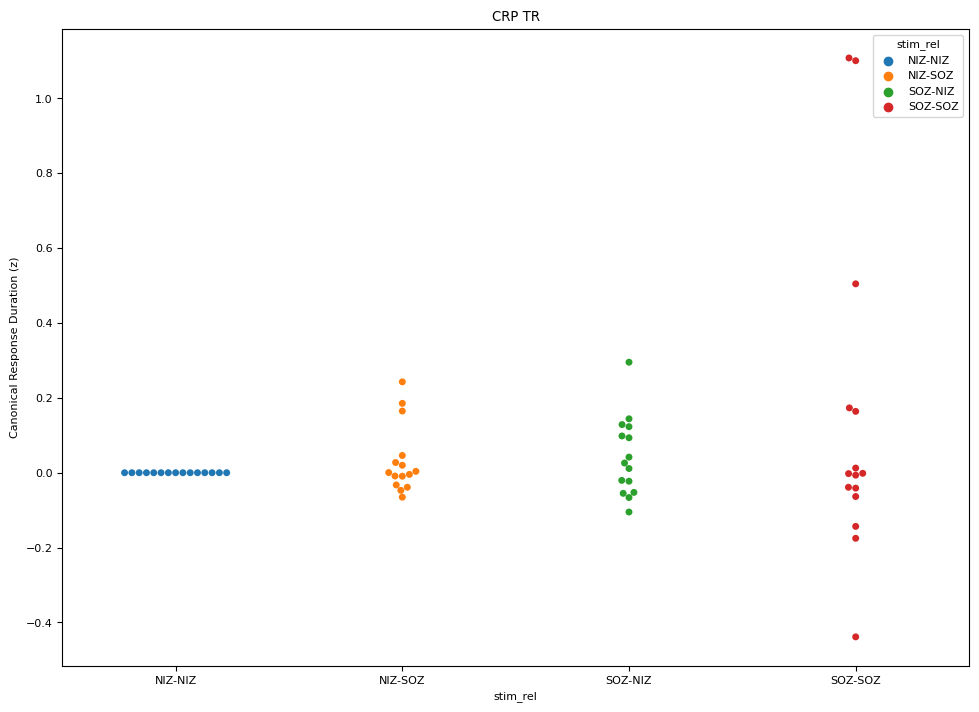

In [46]:
fig, ax = plt.subplots(figsize=[11.7,8.27])


ax = sns.swarmplot(tst_df, x='stim_rel', y='TR_z',hue='stim_rel',ax=ax)
a = tst_df[tst_df.stim_rel=='NIZ-SOZ'].TR_z
b = tst_df[tst_df.stim_rel =='SOZ-SOZ'].TR_z
c = tst_df[tst_df.stim_rel == 'PZ-SOZ'].TR_z
d =  tst_df[tst_df.stim_rel == 'PZ-PZ'].TR_z

# b= ttest_1samp(b,0)
# print(b)
print(f"NIZ-SOZ zscore {np.mean(a)}")
print(f"SOZ-SOZ zscore {np.mean(b)}")
print(ttest_ind(a,b))
# print(ttest_1samp(c,0))
# print(ttest_1samp(d,0) )


plt.ylabel("Canonical Response Duration (z)")
plt.title("CRP TR")
plt.savefig("../viz/relabel_crp_TRz.pdf",transparent=True)

/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

0.6598037623370575
TtestResult(statistic=-6.073370433499019, pvalue=1.5025772096401164e-06, df=28.0)


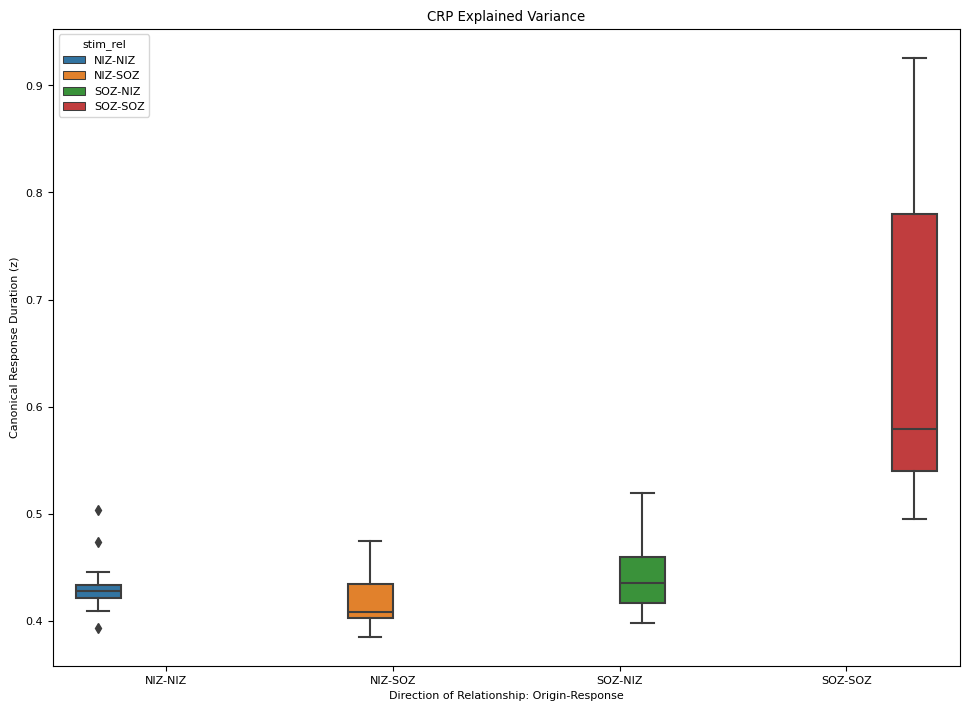

In [47]:

fig, ax = plt.subplots(figsize=[11.7,8.27])


ax = sns.boxplot(tst_df, x='stim_rel', y='explained_variance',hue='stim_rel',ax=ax)
a = tst_df[tst_df.stim_rel=='NIZ-SOZ'].explained_variance
b = tst_df[tst_df.stim_rel =='SOZ-SOZ'].explained_variance
c = tst_df[tst_df.stim_rel == 'PZ-SOZ'].explained_variance
d =  tst_df[tst_df.stim_rel == 'PZ-PZ'].explained_variance

# b= ttest_1samp(b,0)
print(np.mean(b))
print(ttest_ind(a,b))
# print(ttest_1samp(c,0))
# print(ttest_1samp(d,0) )


plt.ylabel("Canonical Response Duration (z)")
plt.title("CRP Explained Variance")
plt.xlabel("Direction of Relationship: Origin-Response")
plt.savefig("../viz/relabel_CRP_ev_box.pdf", transparent=True)

0.6616302080571604
TtestResult(statistic=-5.1223786547553, pvalue=2.4337377734216055e-05, df=26.0)


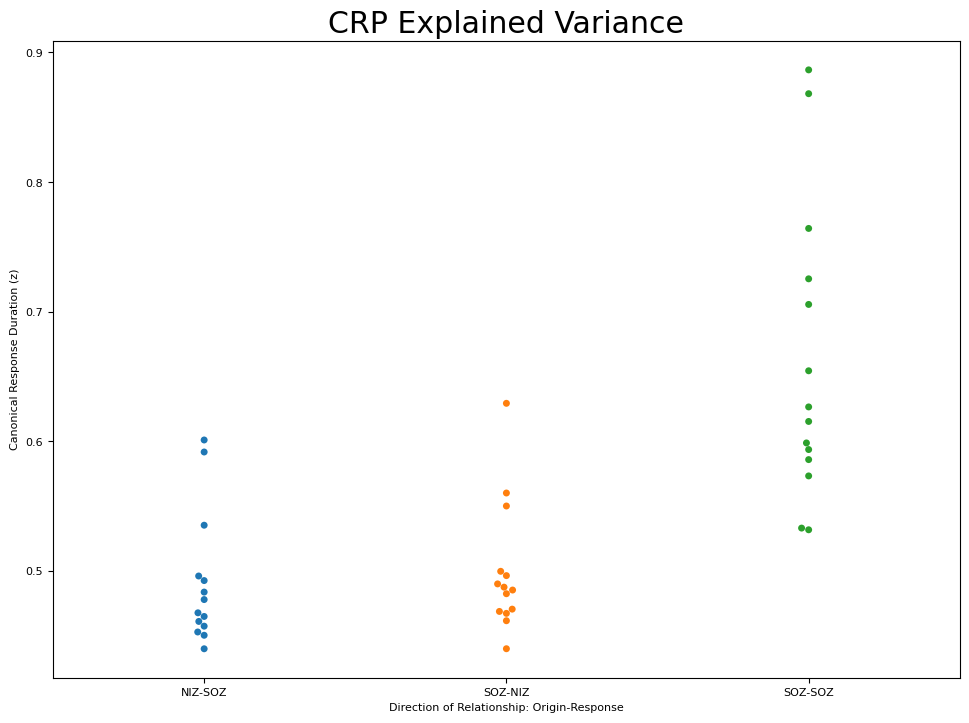

In [47]:
fig, ax = plt.subplots(figsize=[11.7,8.27])
plt.rcParams.update({'font.size': 18})


ax = sns.swarmplot(tst_df[tst_df.stim_rel.isin(cols)], x='stim_rel', y='explained_variance',hue='stim_rel',ax=ax)
a = tst_df[tst_df.stim_rel=='NIZ-SOZ'].explained_variance
b = tst_df[tst_df.stim_rel =='SOZ-SOZ'].explained_variance
c = tst_df[tst_df.stim_rel == 'PZ-SOZ'].explained_variance
d =  tst_df[tst_df.stim_rel == 'PZ-PZ'].explained_variance

# b= ttest_1samp(b,0)
print(np.mean(b))
print(ttest_ind(a,b))
# print(ttest_1samp(c,0))
# print(ttest_1samp(d,0) )


plt.ylabel("Canonical Response Duration (z)")
plt.title("CRP Explained Variance")
plt.xlabel("Direction of Relationship: Origin-Response")

plt.savefig("viz/relabel_CRP_ev_swarm.pdf", transparent=True)

/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

Text(0.5, 1.0, 'Alpha prime Across all locations')

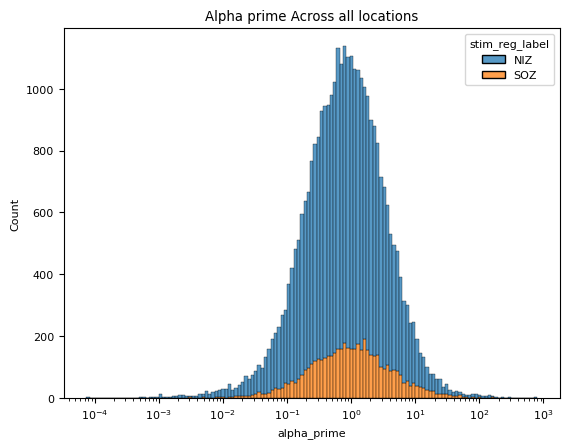

In [48]:
sns.histplot(data=group_df, x= 'alpha_prime', hue='stim_reg_label',multiple='stack',log_scale=True)
plt.title("Alpha prime Across all locations")

/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

Text(0.5, 1.0, 'Alpha prime in SOZ locations')

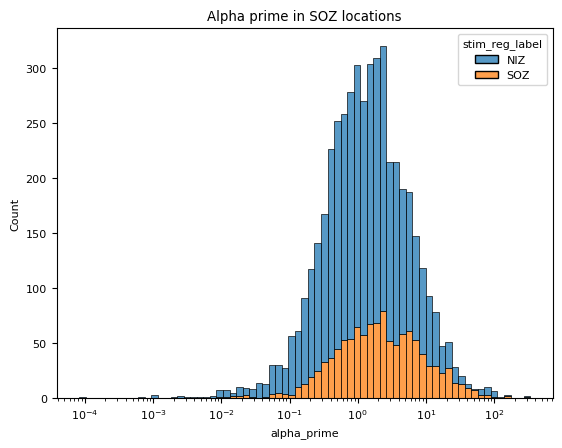

In [49]:
tst = group_df.reset_index()
tst = tst[tst.resp_reg_label =='SOZ']
sns.histplot(data=tst, x= 'alpha_prime', hue='stim_reg_label',multiple='stack',log_scale=True)
plt.title("Alpha prime in SOZ locations")

In [ ]:
tst = group_df.reset_index()
tst = tst[tst.resp_reg_label =='PZ']
sns.histplot(data=tst, x= 'alpha_prime', hue='stim_reg_label',multiple='stack',log_scale=True)
plt.title("Alpha prime in PZ locations")


In [ ]:
sns.violinplot(plot_df[plot_df.subj==plot_df.subj.values[0]],x='resp_reg_label', y='alpha_prime', hue='stim_reg_label', log_scale=True)


In [ ]:

ax = sns.violinplot(plot_df[plot_df.subj=='Epat27'],x='resp_reg_label', y='alpha_prime', hue='stim_reg_label', log_scale=True)
ax.set_ylim(10e-8, 10e3)
plt.title("Epat 27")

In [ ]:
plot_df